<a href="https://colab.research.google.com/github/dgb1106/PM2.5-Prediction/blob/main/PM2.5_LSTM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Load dataset

In [ ]:
file_path = '/content/drive/MyDrive/PM2.5/splitted_data'
df = pd.read_csv(file_path + '/train.csv', parse_dates=['time'])
print(len(df))
df.head()

8055


,time,ID,pm25,lat,lon,SQRT_SEA_DEM_LAT,WSPD,WDIR,TMP,TX,TN,TP,RH,PRES2M
0,2020-01-01,19,116.949130,21.049750,105.741870,5.922647,1.136119,145.942749,20.811243,23.219995,18.939997,0.3750,74.750000,102197.203125
1,2020-01-01,79,105.103043,21.015250,105.800130,4.307231,1.136119,145.942749,20.811243,23.219995,18.939997,0.3750,74.750000,102197.203125
2,2020-01-01,163,118.285100,21.024347,106.017288,4.988467,0.651509,145.395233,20.677492,23.029993,18.879999,0.1250,73.687500,102228.796875
3,2020-01-01,300,116.739130,21.023532,105.853941,4.865087,1.136119,145.942749,20.811243,23.219995,18.939997,0.3750,74.750000,102197.203125
4,2020-01-02,19,76.856667,21.049750,105.741870,5.922647,2.744283,147.084442,22.176249,25.119989,20.299982,0.1875,78.012497,102025.328125


In [ ]:
df = df.sort_values(['ID', 'time']).reset_index(drop=True)
df.head()

,time,ID,pm25,lat,lon,SQRT_SEA_DEM_LAT,WSPD,WDIR,TMP,TX,TN,TP,RH,PRES2M
0,2020-02-26,5,54.661429,21.0213,105.8509,4.865087,3.055647,144.053604,22.779993,26.980005,19.119989,0.0000,71.849998,101519.875000
1,2020-02-29,5,25.771250,21.0213,105.8509,4.865087,4.075986,145.028137,23.912493,27.839991,21.299982,0.6250,75.724998,101098.835938
2,2020-03-01,5,28.635652,21.0213,105.8509,4.865087,3.050910,137.656815,24.142496,27.140009,21.619989,0.5000,78.075005,101089.875000
3,2020-03-02,5,21.906667,21.0213,105.8509,4.865087,4.523894,137.026627,24.297499,26.920008,22.879999,0.3750,75.512505,101164.203125
4,2020-03-03,5,13.835625,21.0213,105.8509,4.865087,4.421610,151.275787,24.263742,27.019983,22.529993,2.4375,76.137505,101179.117188


In [ ]:
df_dev = pd.read_csv(file_path + '/dev.csv', parse_dates=['time'])
df_dev = df_dev.sort_values(['ID', 'time']).reset_index(drop=True)
df_dev.head()

,time,ID,pm25,lat,lon,SQRT_SEA_DEM_LAT,WSPD,WDIR,TMP,TX,TN,TP,RH,PRES2M
0,2021-05-11,19,22.132083,21.04975,105.74187,5.922647,3.800925,159.598328,30.950003,37.550011,25.749994,0.0000,68.562500,100172.304688
1,2021-05-12,19,19.387500,21.04975,105.74187,5.922647,3.296794,165.036392,30.725004,37.249992,26.450006,1.9375,70.900002,100213.265625
2,2021-05-13,19,27.319583,21.04975,105.74187,5.922647,3.155174,172.235855,29.850004,36.749992,25.350000,18.5000,76.275002,100239.085938
3,2021-05-14,19,27.685000,21.04975,105.74187,5.922647,4.464500,164.457855,29.812502,35.849998,25.350000,5.6250,73.537498,100224.226562
4,2021-05-15,19,22.887917,21.04975,105.74187,5.922647,5.185781,157.254791,30.662512,36.650017,26.650019,1.0000,72.699997,100247.953125


In [ ]:
df_test = pd.read_csv(file_path + '/test.csv', parse_dates=['time'])
df_test = df_test.sort_values(['ID', 'time']).reset_index(drop=True)
df_test.head()

,time,ID,pm25,lat,lon,SQRT_SEA_DEM_LAT,WSPD,WDIR,TMP,TX,TN,TP,RH,PRES2M
0,2021-07-28,19,20.842500,21.04975,105.74187,5.922647,0.693913,339.214447,31.200006,35.349998,28.550013,5.6875,69.250000,99606.562500
1,2021-07-29,19,33.892500,21.04975,105.74187,5.922647,0.523525,185.343048,30.625010,35.450005,27.350000,4.5625,74.250000,99763.789062
2,2021-07-30,19,36.941667,21.04975,105.74187,5.922647,1.035424,239.131134,31.162508,35.749992,28.050013,1.9375,70.700005,99807.289062
3,2021-07-31,19,27.620833,21.04975,105.74187,5.922647,0.339110,285.829346,31.512503,36.550011,27.950006,2.6875,68.812500,99719.101562
4,2021-08-01,19,16.318571,21.04975,105.74187,5.922647,2.293170,297.920013,26.387503,27.950006,24.950006,16.7500,88.875000,99834.156250


In [ ]:
def month_to_season(month):
    if month in [12, 1, 2]:
        return 0  # Winter
    elif month in [3, 4, 5]:
        return 1  # Spring
    elif month in [6, 7, 8]:
        return 2  # Summer
    else:
        return 3  # Autumn

def add_season_features(dataframe):
    # Convert month to season
    dataframe['season'] = dataframe['time'].dt.month.apply(month_to_season)

    # Create one-hot encoding with all possible seasons
    all_seasons = [0, 1, 2, 3]  # Winter, Spring, Summer, Autumn
    for season in all_seasons:
        dataframe[f'season_{season}'] = (dataframe['season'] == season).astype(int)

    # Drop original season column
    dataframe.drop(columns=['season'], inplace=True)

    return dataframe

In [ ]:
def engineering_features(df):
    df['time'] = pd.to_datetime(df['time'])
    df['month'] = df['time'].dt.month

    df = add_season_features(df)

    df['pm25_lag1'] = np.log1p(df['pm25'].shift(1))
    df['pm25_lag2'] = np.log1p(df['pm25'].shift(2))
    df['pm25_lag3'] = np.log1p(df['pm25'].shift(3))

    df['pm25_roll_mean_2'] = df["pm25"].shift(1).rolling(window=2).mean()
    df["pm25_roll_std_2"] = df["pm25"].shift(1).rolling(window=2).std()
    df["pm25_roll_mean_3"] = df["pm25"].shift(1).rolling(window=3).mean()
    df["pm25_roll_std_3"] = df["pm25"].shift(1).rolling(window=3).std()

    # 4. Xử lý NaN
    df = df.dropna().reset_index(drop=True)

    df['pm25'] = np.log1p(df['pm25'])

    return df

In [ ]:
df = engineering_features(df)
df_dev = engineering_features(df_dev)
df_test = engineering_features(df_test)

In [ ]:
df.head()

,time,ID,pm25,lat,lon,SQRT_SEA_DEM_LAT,WSPD,WDIR,TMP,TX,...,season_1,season_2,season_3,pm25_lag1,pm25_lag2,pm25_lag3,pm25_roll_mean_2,pm25_roll_std_2,pm25_roll_mean_3,pm25_roll_std_3
0,2020-03-02,5,3.131428,21.0213,105.8509,4.865087,4.523894,137.026627,24.297499,26.920008,...,1,0,0,3.388978,3.287329,4.019287,27.203451,2.025438,36.356110,15.917434
1,2020-03-03,5,2.697031,21.0213,105.8509,4.865087,4.421610,151.275787,24.263742,27.019983,...,1,0,0,3.131428,3.388978,3.287329,25.271159,4.758111,25.437856,3.376859
2,2020-03-04,5,2.890217,21.0213,105.8509,4.865087,3.464476,79.480682,20.423742,23.089991,...,1,0,0,2.697031,3.131428,3.388978,17.871146,5.707088,21.459315,7.410148
3,2020-03-07,5,3.372369,21.0213,105.8509,4.865087,2.818136,133.328522,23.942495,28.920008,...,1,0,0,2.890217,2.697031,3.131428,15.416424,2.235587,17.579838,4.066941
4,2020-03-08,5,3.653457,21.0213,105.8509,4.865087,1.927126,122.793274,26.831251,36.779991,...,1,0,0,3.372369,2.890217,2.697031,22.572361,7.884437,19.660116,7.518357


In [ ]:
df_dev.head()

,time,ID,pm25,lat,lon,SQRT_SEA_DEM_LAT,WSPD,WDIR,TMP,TX,...,season_1,season_2,season_3,pm25_lag1,pm25_lag2,pm25_lag3,pm25_roll_mean_2,pm25_roll_std_2,pm25_roll_mean_3,pm25_roll_std_3
0,2021-05-14,19,3.356374,21.04975,105.74187,5.922647,4.464500,164.457855,29.812502,35.849998,...,1,0,0,3.343554,3.014922,3.141221,23.353542,5.608830,22.946389,4.028251
1,2021-05-15,19,3.173373,21.04975,105.74187,5.922647,5.185781,157.254791,30.662512,36.650017,...,1,0,0,3.356374,3.343554,3.014922,27.502292,0.258389,24.797361,4.688638
2,2021-05-16,19,3.182523,21.04975,105.74187,5.922647,3.752593,156.022003,30.675009,37.150017,...,1,0,0,3.173373,3.356374,3.343554,25.286458,3.392050,25.964167,2.670368
3,2021-05-17,19,3.033590,21.04975,105.74187,5.922647,4.172164,147.852692,29.337507,33.749992,...,1,0,0,3.182523,3.173373,3.356374,22.997708,0.155269,24.560139,2.708435
4,2021-05-18,19,3.099773,21.04975,105.74187,5.922647,4.497660,140.740845,29.110003,33.150017,...,1,0,0,3.033590,3.182523,3.173373,21.439583,2.358790,21.922361,1.865789


In [ ]:
df_test.head()

,time,ID,pm25,lat,lon,SQRT_SEA_DEM_LAT,WSPD,WDIR,TMP,TX,...,season_1,season_2,season_3,pm25_lag1,pm25_lag2,pm25_lag3,pm25_roll_mean_2,pm25_roll_std_2,pm25_roll_mean_3,pm25_roll_std_3
0,2021-07-31,19,3.354135,21.04975,105.74187,5.922647,0.339110,285.829346,31.512503,36.550011,...,0,1,0,3.636050,3.552272,3.083858,35.417083,2.156086,30.558889,8.551638
1,2021-08-01,19,2.851779,21.04975,105.74187,5.922647,2.293170,297.920013,26.387503,27.950006,...,0,1,0,3.354135,3.636050,3.552272,32.281250,6.590824,32.818333,4.752353
2,2021-08-02,19,3.169826,21.04975,105.74187,5.922647,1.376523,294.633423,29.887506,36.150017,...,0,1,0,2.851779,3.354135,3.636050,21.969702,7.991906,26.960357,10.327400
3,2021-08-03,19,3.514772,21.04975,105.74187,5.922647,1.459764,311.250549,31.087507,37.150017,...,0,1,0,3.169826,2.851779,3.354135,19.560952,4.585419,22.247579,5.671590
4,2021-08-04,19,3.786413,21.04975,105.74187,5.922647,1.460672,320.834778,30.675005,36.749992,...,0,1,0,3.514772,3.169826,2.851779,27.705797,6.933131,23.910055,8.201044


# Compute correlation and create scenarios

In [ ]:
def compute_correlation(df, target='pm25'):
    correlations = []
    for col in df.columns:
        if col not in ['index', 'time', 'ID', target]:
            corr = df[col].corr(df[target])
            correlations.append((col, corr))
    correlations.sort(key=lambda x: abs(x[1]), reverse=True)
    return correlations

In [ ]:
correlations = compute_correlation(df)
for col, r in correlations:
    print(f'{col:20s} -> Pearson r = {r:.3f}')

pm25_lag1            -> Pearson r = 0.826
pm25_roll_mean_2     -> Pearson r = 0.689
pm25_lag2            -> Pearson r = 0.666
pm25_roll_mean_3     -> Pearson r = 0.660
pm25_lag3            -> Pearson r = 0.586
pm25_roll_std_3      -> Pearson r = 0.450
PRES2M               -> Pearson r = 0.399
pm25_roll_std_2      -> Pearson r = 0.388
season_0             -> Pearson r = 0.386
TN                   -> Pearson r = -0.347
TP                   -> Pearson r = -0.343
season_2             -> Pearson r = -0.303
TMP                  -> Pearson r = -0.295
WSPD                 -> Pearson r = -0.271
RH                   -> Pearson r = -0.259
TX                   -> Pearson r = -0.228
month                -> Pearson r = -0.221
lon                  -> Pearson r = -0.163
SQRT_SEA_DEM_LAT     -> Pearson r = 0.150
season_3             -> Pearson r = -0.148
lat                  -> Pearson r = -0.030
season_1             -> Pearson r = -0.017
WDIR                 -> Pearson r = 0.012


In [ ]:
features_s1 = ['SQRT_SEA_DEM_LAT', 'WSPD', 'WDIR', 'TMP', 'TX', 'TN', 'TP', 'RH', 'PRES2M']
features_s2 = features_s1 + ['pm25_lag1', 'pm25_lag2', 'pm25_lag3']
features_s3 = features_s2 + ['month', 'season_0', 'season_1', 'season_2', 'season_3']
features_s4 = features_s3 + ['pm25_roll_mean_2', 'pm25_roll_mean_3', 'pm25_roll_std_2', 'pm25_roll_std_3']

# Create sequence for LSTM

In [ ]:
from sklearn.preprocessing import MinMaxScaler, StandardScaler, RobustScaler

scaler_X = StandardScaler()
scaler_y = StandardScaler()

features = features_s1

target = 'pm25'

df[features] = scaler_X.fit_transform(df[features])
df[target] = scaler_y.fit_transform(df[[target]])

df.head()

,time,ID,pm25,lat,lon,SQRT_SEA_DEM_LAT,WSPD,WDIR,TMP,TX,...,season_1,season_2,season_3,pm25_lag1,pm25_lag2,pm25_lag3,pm25_roll_mean_2,pm25_roll_std_2,pm25_roll_mean_3,pm25_roll_std_3
0,2020-03-02,5,-0.427675,21.0213,105.8509,-0.7224,1.244798,0.179981,0.118810,-0.125881,...,1,0,0,3.388978,3.287329,4.019287,27.203451,2.025438,36.356110,15.917434
1,2020-03-03,5,-1.029161,21.0213,105.8509,-0.7224,1.166477,0.367215,0.112127,-0.109256,...,1,0,0,3.131428,3.388978,3.287329,25.271159,4.758111,25.437856,3.376859
2,2020-03-04,5,-0.761667,21.0213,105.8509,-0.7224,0.433579,-0.576172,-0.648175,-0.762794,...,1,0,0,2.697031,3.131428,3.388978,17.871146,5.707088,21.459315,7.410148
3,2020-03-07,5,-0.094057,21.0213,105.8509,-0.7224,-0.061338,0.131388,0.048521,0.206709,...,1,0,0,2.890217,2.697031,3.131428,15.416424,2.235587,17.579838,4.066941
4,2020-03-08,5,0.295151,21.0213,105.8509,-0.7224,-0.743604,-0.007045,0.620481,1.513784,...,1,0,0,3.372369,2.890217,2.697031,22.572361,7.884437,19.660116,7.518357


In [ ]:
df_dev[features] = scaler_X.transform(df_dev[features])
df_dev[target] = scaler_y.transform(df_dev[[target]])

df_dev.head()

,time,ID,pm25,lat,lon,SQRT_SEA_DEM_LAT,WSPD,WDIR,TMP,TX,...,season_1,season_2,season_3,pm25_lag1,pm25_lag2,pm25_lag3,pm25_roll_mean_2,pm25_roll_std_2,pm25_roll_mean_3,pm25_roll_std_3
0,2021-05-14,19,-0.116204,21.04975,105.74187,0.975704,1.199319,0.540428,1.210754,1.359131,...,1,0,0,3.343554,3.014922,3.141221,23.353542,5.608830,22.946389,4.028251
1,2021-05-15,19,-0.369597,21.04975,105.74187,0.975704,1.751620,0.445779,1.379052,1.492170,...,1,0,0,3.356374,3.343554,3.014922,27.502292,0.258389,24.797361,4.688638
2,2021-05-16,19,-0.356927,21.04975,105.74187,0.975704,0.654196,0.429581,1.381527,1.575318,...,1,0,0,3.173373,3.356374,3.343554,25.286458,3.392050,25.964167,2.670368
3,2021-05-17,19,-0.563147,21.04975,105.74187,0.975704,0.975471,0.322236,1.116708,1.009911,...,1,0,0,3.182523,3.173373,3.356374,22.997708,0.155269,24.560139,2.708435
4,2021-05-18,19,-0.471506,21.04975,105.74187,0.975704,1.224710,0.228786,1.071663,0.910138,...,1,0,0,3.033590,3.182523,3.173373,21.439583,2.358790,21.922361,1.865789


In [ ]:
df_test[features] = scaler_X.transform(df_test[features])
df_test[target] = scaler_y.transform(df_test[[target]])

df_test.head()

,time,ID,pm25,lat,lon,SQRT_SEA_DEM_LAT,WSPD,WDIR,TMP,TX,...,season_1,season_2,season_3,pm25_lag1,pm25_lag2,pm25_lag3,pm25_roll_mean_2,pm25_roll_std_2,pm25_roll_mean_3,pm25_roll_std_3
0,2021-07-31,19,-0.119305,21.04975,105.74187,0.975704,-1.959582,2.135248,1.547346,1.475540,...,0,1,0,3.636050,3.552272,3.083858,35.417083,2.156086,30.558889,8.551638
1,2021-08-01,19,-0.814890,21.04975,105.74187,0.975704,-0.463316,2.294119,0.532621,0.045402,...,0,1,0,3.354135,3.636050,3.552272,32.281250,6.590824,32.818333,4.752353
2,2021-08-02,19,-0.374508,21.04975,105.74187,0.975704,-1.165212,2.250933,1.225605,1.409023,...,0,1,0,2.851779,3.354135,3.636050,21.969702,7.991906,26.960357,10.327400
3,2021-08-03,19,0.103121,21.04975,105.74187,0.975704,-1.101472,2.469282,1.463199,1.575318,...,0,1,0,3.169826,2.851779,3.354135,19.560952,4.585419,22.247579,5.671590
4,2021-08-04,19,0.479248,21.04975,105.74187,0.975704,-1.100777,2.595219,1.381526,1.508796,...,0,1,0,3.514772,3.169826,2.851779,27.705797,6.933131,23.910055,8.201044


In [ ]:
from torch.utils.data import Dataset, DataLoader

class SequenceDataset(Dataset):
    def __init__(self, data, features, target='pm25', sequence_length=7, n_future=1):
        self.X = []
        self.y = []
        grouped = data.groupby('ID')

        for _, group in grouped:
            group = group.sort_values('time').reset_index(drop=True)
            values = group[features + [target]].values

            for i in range(sequence_length, len(values) - n_future + 1):
                self.X.append(values[i-sequence_length:i, :-1])
                self.y.append(values[i:i+n_future, -1])

        self.X = torch.tensor(self.X, dtype=torch.float32)
        self.y = torch.tensor(self.y, dtype=torch.float32)

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

# Model construction

In [ ]:
class LSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size, dropout, num_layers, n_future=1):
        super(LSTMModel, self).__init__()

        self.lstm = nn.LSTM(
            input_size=input_size,
            hidden_size=hidden_size,
            num_layers=num_layers,
            batch_first=True,
            dropout=dropout if num_layers > 1 else 0  # PyTorch chỉ apply dropout nếu num_layers > 1
        )

        self.fc = nn.Sequential(
            nn.Linear(hidden_size, 32),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(32, n_future)
        )

    def forward(self, x):
        lstm_out, _ = self.lstm(x)
        x = lstm_out[:, -1, :]
        out = self.fc(x)
        return out

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

n_future = 1
sequence_length = 4
batch_size = 32
hidden_size = 64
dropout = 0.1
num_layers = 1

data_train = SequenceDataset(df, features, target=target, sequence_length=sequence_length)
loader_train = DataLoader(data_train, batch_size=batch_size, shuffle=True)

data_dev = SequenceDataset(df_dev, features, target=target, sequence_length=sequence_length)
loader_dev = DataLoader(data_dev, batch_size=batch_size, shuffle=False)

data_test = SequenceDataset(df_test, features, target=target, sequence_length=sequence_length)
loader_test = DataLoader(data_test, batch_size=batch_size, shuffle=False)

model = LSTMModel(input_size=len(features), hidden_size=hidden_size, dropout=dropout, num_layers=num_layers).to(device)

loss_fn = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.0005, weight_decay=1e-5)

In [ ]:
epochs = 50
best_val_loss = float('inf')
patience = 5
counter = 0

for epoch in range(epochs):
    model.train()

    total_loss = 0

    for x_batch, y_batch in loader_train:
        x_batch, y_batch = x_batch.to(device), y_batch.to(device)
        optimizer.zero_grad()
        y_pred = model(x_batch)
        loss = loss_fn(y_pred, y_batch)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()

    print(f"Epoch {epoch+1}/{epochs}: Loss = {total_loss/len(loader_train):.4f}")

    model.eval()
    val_loss = 0
    with torch.no_grad():
        for x_batch, y_batch in loader_dev:
            x_batch, y_batch = x_batch.to(device), y_batch.to(device)
            y_pred = model(x_batch)
            val_loss += loss_fn(y_pred, y_batch).item()

    val_loss = val_loss/len(loader_dev)
    print(f"Validation Loss: {val_loss:.4f}")

    if val_loss < best_val_loss:
        best_val_loss = val_loss
        torch.save(model.state_dict(), 'best_model.pt')
        counter = 0
    else:
        counter += 1
        if counter >= patience:
            print("Early stopping")
            break

Epoch 1/50: Loss = 0.6972
Validation Loss: 0.6912
Epoch 2/50: Loss = 0.5787
Validation Loss: 0.6617
Epoch 3/50: Loss = 0.5526
Validation Loss: 0.7280
Epoch 4/50: Loss = 0.5313
Validation Loss: 0.6909
Epoch 5/50: Loss = 0.5169
Validation Loss: 0.6430
Epoch 6/50: Loss = 0.5043
Validation Loss: 0.6727
Epoch 7/50: Loss = 0.4911
Validation Loss: 0.6677
Epoch 8/50: Loss = 0.4833
Validation Loss: 0.6726
Epoch 9/50: Loss = 0.4728
Validation Loss: 0.6981
Epoch 10/50: Loss = 0.4679
Validation Loss: 0.6852
Early stopping


In [ ]:
def calculate_ioa(obs, pred):
    numerator = np.sum((pred - obs) ** 2)
    denominator = np.sum((np.abs(pred - np.mean(obs)) + np.abs(obs - np.mean(obs))) ** 2)
    ioa = 1 - numerator / denominator
    return ioa

def calculate_nmb(obs, pred):
    nmb = np.sum(pred - obs) / np.sum(obs)
    return nmb

In [ ]:
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from scipy.stats import pearsonr

def get_scores(model, loader):
    model.eval()
    y_true, y_pred = [], []

    with torch.no_grad():
        for X_batch, y_batch in loader:
            X_batch = X_batch.to(device)
            outputs = model(X_batch)
            y_pred.extend(outputs.cpu().numpy())
            y_true.extend(y_batch.numpy())

    y_true_inv = np.expm1(scaler_y.inverse_transform(np.array(y_true).reshape(-1, 1)))
    y_pred_inv = np.expm1(scaler_y.inverse_transform(np.array(y_pred).reshape(-1, 1)))

    rmse = np.sqrt(mean_squared_error(y_true_inv, y_pred_inv))
    mae = mean_absolute_error(y_true_inv, y_pred_inv)
    r2 = r2_score(y_true_inv, y_pred_inv)
    r, _ = pearsonr(np.array(y_true_inv).flatten(), np.array(y_pred_inv).flatten())
    ioa = calculate_ioa(y_true_inv, y_pred_inv)
    nmb = calculate_nmb(y_true_inv, y_pred_inv)

    print(f"RMSE: {rmse:.4f}")
    print(f"MAE: {mae:.4f}")
    print(f"R2: {r2:.4f}")
    print(f"Pearson r: {r:.4f}")
    print(f"IOA: {ioa:.4f}")
    print(f"NMB: {nmb:.4f}")

    return y_true_inv, y_pred_inv

In [ ]:
import matplotlib.pyplot as plt

def plot(y_true_inv, y_pred_inv):
    plt.figure(figsize=(10, 6))
    plt.plot(y_true_inv, label='Actual')
    plt.plot(y_pred_inv, label='Predicted')
    plt.title('Actual vs Predicted PM2.5 by LSTM')
    plt.xlabel('Days')
    plt.ylabel('PM2.5')
    plt.legend()
    plt.show()

RMSE: 20.8544
MAE: 13.6781
R2: 0.5583
Pearson r: 0.7684
IOA: 0.8214
NMB: -0.0953


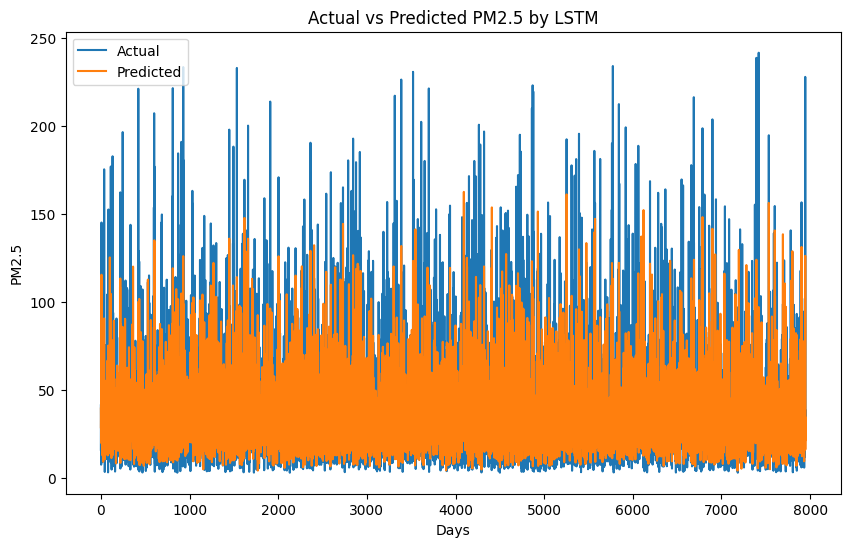

In [ ]:
# train test
y_true_inv, y_pred_inv = get_scores(model, loader_train)
plot(y_true_inv, y_pred_inv)

RMSE: 14.8338
MAE: 10.3874
R2: 0.0776
Pearson r: 0.3411
IOA: 0.5262
NMB: 0.0626


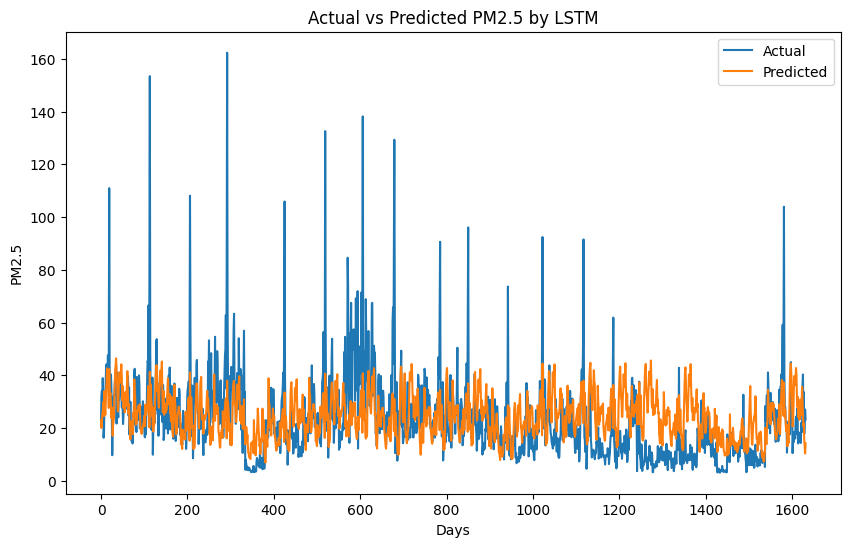

In [ ]:
# dev test
y_true_inv, y_pred_inv = get_scores(model, loader_dev)
plot(y_true_inv, y_pred_inv)

In [ ]:
# import optuna
# import numpy as np
# import torch
# import torch.nn as nn
# from torch.utils.data import DataLoader
# from sklearn.metrics import mean_squared_error

# # Be sure you have already defined:
# # - df, df_dev, features, target, sequence_length, n_future, device
# # - SequenceDataset, LSTMModel
# # - scaler_y for inverse-transform of the target

# def objective(trial):
#     # 1. Sample hyperparameters
#     hidden_size = trial.suggest_int("hidden_size", 32, 256, step=32)
#     num_layers  = trial.suggest_int("num_layers", 1, 4)
#     dropout     = trial.suggest_float("dropout", 0.0, 0.5)
#     lr          = trial.suggest_loguniform("lr", 1e-4, 1e-1)
#     batch_size  = trial.suggest_categorical("batch_size", [32, 64, 128])
#     epochs      = 30  # keep this modest for tuning

#     # 2. Create data loaders
#     train_ds = SequenceDataset(df,     features, target=target,
#                                sequence_length=sequence_length,
#                                n_future=n_future)
#     dev_ds   = SequenceDataset(df_dev, features, target=target,
#                                sequence_length=sequence_length,
#                                n_future=n_future)
#     train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True)
#     dev_loader   = DataLoader(dev_ds,   batch_size=batch_size, shuffle=False)

#     # 3. Build model, optimizer, loss
#     model = LSTMModel(input_size=len(features),
#                       hidden_size=hidden_size,
#                       num_layers=num_layers,
#                       dropout=dropout,
#                       n_future=n_future).to(device)
#     optimizer = torch.optim.Adam(model.parameters(), lr=lr)
#     loss_fn   = nn.MSELoss()

#     # 4. Training loop with optional pruning
#     for epoch in range(1, epochs+1):
#         model.train()
#         for Xb, yb in train_loader:
#             Xb, yb = Xb.to(device), yb.to(device)
#             optimizer.zero_grad()
#             pred = model(Xb)               # [B, n_future]
#             loss = loss_fn(pred, yb)
#             loss.backward()
#             torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
#             optimizer.step()

#         # run a quick validation at end of each epoch
#         model.eval()
#         y_true, y_pred = [], []
#         with torch.no_grad():
#             for Xb, yb in dev_loader:
#                 Xb = Xb.to(device)
#                 out = model(Xb).cpu().numpy()
#                 y_pred.append(out)
#                 y_true.append(yb.numpy())
#         y_true = np.vstack(y_true)
#         y_pred = np.vstack(y_pred)
#         # invert scaling to real PM2.5
#         y_true_real = scaler_y.inverse_transform(y_true)
#         y_pred_real = scaler_y.inverse_transform(y_pred)
#         rmse = float(np.sqrt(mean_squared_error(y_true_real, y_pred_real)))

#         # report intermediate objective value for pruning
#         trial.report(rmse, epoch)
#         if trial.should_prune():
#             raise optuna.exceptions.TrialPruned()

#     return rmse

# # 5. Run the study
# study = optuna.create_study(
#     direction="minimize",
#     pruner=optuna.pruners.MedianPruner(n_startup_trials=5, n_warmup_steps=2)
# )
# study.optimize(objective, n_trials=50, timeout=3600)

# print("Best RMSE: ", study.best_value)
# print("Best hyperparameters:")
# for k, v in study.best_trial.params.items():
#     print(f"  {k}: {v}")

# # 6. (Optional) Train final model on train+dev with best params:
# best = study.best_trial.params
# final_ds = SequenceDataset(
#     pd.concat([df, df_dev]).reset_index(drop=True),
#     features, target,
#     sequence_length, n_future
# )
# final_loader = DataLoader(final_ds, batch_size=best["batch_size"], shuffle=True)
# final_model = LSTMModel(
#     input_size=len(features),
#     hidden_size=best["hidden_size"],
#     num_layers=best["num_layers"],
#     dropout=best["dropout"],
#     n_future=n_future
# ).to(device)
# optimizer = torch.optim.Adam(final_model.parameters(), lr=best["lr"])
# loss_fn   = nn.MSELoss()

# for epoch in range(1, 51):
#     final_model.train()
#     for Xb, yb in final_loader:
#         Xb, yb = Xb.to(device), yb.to(device)
#         optimizer.zero_grad()
#         loss_fn(final_model(Xb), yb).backward()
#         optimizer.step()

# torch.save(final_model.state_dict(), "lstm_optuna_tuned.pt")

In [ ]:
# # dev test
# y_true_inv, y_pred_inv = get_scores(final_model, loader_dev)
# plot(y_true_inv, y_pred_inv)

In [ ]:
# # test test
# y_true_inv, y_pred_inv = get_scores(final_model, loader_test)
# plot(y_true_inv, y_pred_inv)